In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=12,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=12,
                                         shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [4]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

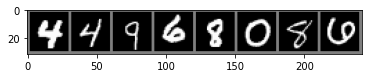

    4     4     9     6     8     0     8     6


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:8]
labels = labels[:8]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join("%5s" % classes[labels[i]] for i in range(8)))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = self._make_layers([64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M'])
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 10),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

In [8]:
vgg11 = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11.parameters(), lr=0.001, momentum=0.9)
vgg11 = vgg11.to(device)

In [10]:
running_loss = 0.0
for i, data in enumerate(trainloader):
    # get the inputs; data is a list of [inputs, labels]
    # shape of `inputs`: (12, 1, 28, 28)
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = vgg11(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if (i + 1) % 100 == 0:    # print every 100 mini-batches
        print('With %d batches, loss: %.3f' %
                (i + 1, running_loss / 100))
        running_loss = 0.0
    if i == 1000:
        break

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


With 100 batches, loss: 1.857
With 200 batches, loss: 0.530
With 300 batches, loss: 0.284
With 400 batches, loss: 0.246
With 500 batches, loss: 0.197
With 600 batches, loss: 0.152
With 700 batches, loss: 0.176
With 800 batches, loss: 0.134
With 900 batches, loss: 0.174
With 1000 batches, loss: 0.138


In [11]:
PATH = './mnist_vgg11.pth'
torch.save(vgg11.state_dict(), PATH)

In [12]:
vgg11 = Net()
vgg11.load_state_dict(torch.load(PATH))

if torch.cuda.is_available():
    vgg11.cuda()

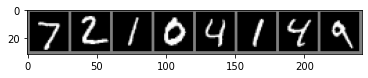

GroundTruth:    7   2   1   0   4   1   4   9
Predicted:      7   2   1   0   4   1   4   9


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images, labels = images[:8], labels[:8]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%3s' % classes[labels[i]] for i in range(8)))

images = images.to(device)
outputs = vgg11(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%3s' % classes[predicted[i]] for i in range(8)))

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg11(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %
